# Project Overview
In this project, I will analyze the results of an A/B test and create a presentation of data-driven recommendations based on my findings.

# Project Background
An A/B test is an experimentation technique used by businesses to compare two versions of a webpage, advertisement, or product feature to determine which one performs better. By randomly assigning customers or users to either the A or B version, the business can determine which version is more effective at achieving a particular goal.

I am a Data Analyst for an e-commerce company called GloBox. GloBox is an online marketplace that specializes in sourcing unique and high-quality products from around the world.

"We believe that shopping should be an adventure, and we want to bring the world to your doorstep. From exotic spices and rare teas to handmade jewelry and textiles, we have a curated selection of products that you won't find anywhere else."

GloBox is primarily known amongst its customer base for boutique fashion items and high-end decor products. However, their food and drink offerings have grown tremendously in the last few months, and the company wants to bring awareness to this product category to increase revenue.

The Growth team decides to run an A/B test that highlights key products in the food and drink category as a banner at the top of the website. The control group does not see the banner, and the test group sees it.

## The setup of the A/B test is as follows:

The experiment is only being run on the mobile website.
A user visits the GloBox main page and is randomly assigned to either the control or test group. This is the join date for the user.
The page loads the banner if the user is assigned to the test group, and does not load the banner if the user is assigned to the control group.
The user subsequently may or may not purchase products from the website. It could be on the same day they join the experiment, or days later. If they do make one or more purchases, this is considered a “conversion”.
My task is to analyze the results of the A/B test and provide a recommendation to my stakeholders about whether GloBox should launch the experience to all users.

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading in the data

df = pd.read_csv('query_results_2.csv')

df.head()

,user_id,country,gender,group,num_purchase_days,total_spent,converted
0,1000000,CAN,M,B,0,NaN,0
1,1000001,BRA,M,A,0,NaN,0
2,1000002,FRA,M,A,0,NaN,0
3,1000003,BRA,M,B,0,NaN,0
4,1000004,DEU,F,A,0,NaN,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48943 entries, 0 to 48942
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            48943 non-null  int64  
 1   country            48300 non-null  object 
 2   gender             42088 non-null  object 
 3   group              48943 non-null  object 
 4   num_purchase_days  48943 non-null  int64  
 5   total_spent        2094 non-null   float64
 6   converted          48943 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.6+ MB


In [4]:
df['converted'].value_counts()

0    46849
1     2094
Name: converted, dtype: int64

In [5]:
df['num_purchase_days'].value_counts()

0    46849
1     1955
2      139
Name: num_purchase_days, dtype: int64

# Cleaning
Although I did some aggregation before pulling this data from SQL I still need to do a little cleanup.
I will:

- total_spent: For customers who did not convert I will replace their null values with 0
- country I will to fill the nulls with UNK meaning unknown 
- gender I will fill the nulls with U, meaning unknown
- converted should be made into a boolean

In [6]:
# Filling null values

df['total_spent'].fillna(0, inplace=True)
df['country'].fillna('UNK', inplace=True)
df['gender'].fillna('U', inplace=True)

In [7]:
# converting 'converted' to a boolean

df['converted'] = df['converted'].astype(bool)

# check

print(df.dtypes)

user_id                int64
country               object
gender                object
group                 object
num_purchase_days      int64
total_spent          float64
converted               bool
dtype: object


In [8]:
# more checking

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48943 entries, 0 to 48942
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            48943 non-null  int64  
 1   country            48943 non-null  object 
 2   gender             48943 non-null  object 
 3   group              48943 non-null  object 
 4   num_purchase_days  48943 non-null  int64  
 5   total_spent        48943 non-null  float64
 6   converted          48943 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 2.3+ MB


In [9]:
df.to_csv('cleaned.csv', index = False)

## Testing

### Null Hypothesis:
- There is no difference in conversion rates between the control and test groups.
### Alternative Hypothesis
- That there is a significant difference in conversion rates between the control and test groups.

### Methods
- Separate the converted column into two groups based on the group column
- Calculate the t-statistic and p-value of a two-sample t-test

In [10]:
# Separate the converted column into two groups based on the group column
control = df[df['group'] == 'A']['converted']
test = df[df['group'] == 'B']['converted']

# Calculate the t-statistic and p-value of a two-sample t-test
t_stat, p_val = ttest_ind(control, test)

# Print out the t-statistic and p-value
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')

# Determine if the p-value is less than the significance level of 0.05
if p_val < 0.05:
    print('There is a significant difference in conversion rates between the control and test groups')
else:
    print('There is no significant difference in conversion rates between the control and test groups')


T-statistic: -3.864802444795058
P-value: 0.00011132252128659758
There is a significant difference in conversion rates between the control and test groups


The t-statistic is -3.8648 and the p-value is 0.0001. Since the p-value is less than the significance level of 0.05, we can reject the null hypothesis and conclude that there is a significant difference in conversion rates between the control and test groups.

In [11]:
# Calculate the conversion rates for control and test groups
control_conv = df[df['group'] == 'A']['converted'].mean()
test_conv = df[df['group'] == 'B']['converted'].mean()

# Calculate the standard error for the difference in proportions
se = np.sqrt((control_conv * (1 - control_conv) / df[df['group'] == 'A'].shape[0]) + (test_conv * (1 - test_conv) / df[df['group'] == 'B'].shape[0]))

# Calculate the margin of error for a 95% confidence interval
me = 1.96 * se

# Calculate the lower and upper bounds of the confidence interval
lower = (test_conv - control_conv) - me
upper = (test_conv - control_conv) + me

print(f'95% Confidence Interval: ({lower}, {upper})')

95% Confidence Interval: (0.0034859853091298585, 0.010653659850210453)


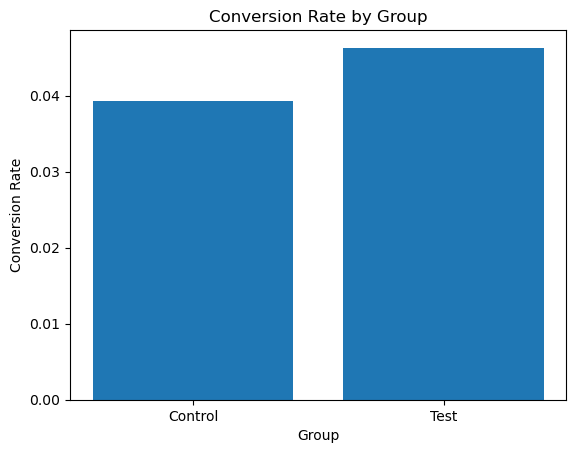

In [12]:
# Calculate the conversion rate for each group
control_rate = df[df['group'] == 'A']['converted'].mean()
test_rate = df[df['group'] == 'B']['converted'].mean()

# Create a bar plot to visualize the conversion rate for each group
plt.bar(['Control', 'Test'], [control_rate, test_rate])
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.show()

In [13]:
# Calculate the conversion rate for each group as a percentage
control_rate = df[df['group'] == 'A']['converted'].mean() * 100
test_rate = df[df['group'] == 'B']['converted'].mean() * 100

print(f'{control_rate:2f}% of control customers converted')
print(f'{test_rate:2f}% of test customers converted')

3.923099% of control customers converted
4.630081% of test customers converted


### Null Hypothesis:
- There is no statistically significant difference in the total spent between the two groups
### Alternative Hypothesis
- There is a significant difference in the total spent between the two groups

### Methods
- Calculate the mean total spent for each group
- Calculate the standard deviation of the total spent for each group
- Calculate the sample size for each group
- Perform the two-sample t-test

In [14]:
# Calculate the mean total spent for each group

control_mean = df[df['group'] == 'A']['total_spent'].mean()
test_mean = df[df['group'] == 'B']['total_spent'].mean()

# Calculate the standard deviation of the total spent for each group

control_std = df[df['group'] == 'A']['total_spent'].std()
test_std = df[df['group'] == 'B']['total_spent'].std()

# Calculate the sample size for each group

control_n = df[df['group'] == 'A']['total_spent'].count()
test_n = df[df['group'] == 'B']['total_spent'].count()

# Perform the two-sample t-test

t_stat, p_val = ttest_ind(df[df['group'] == 'A']['total_spent'], df[df['group'] == 'B']['total_spent'], equal_var=False)

# Print the results of the t-test

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')
print(f'The control group spent an average of ${control_mean:2f}')
print(f'The test group spent an average of ${test_mean:2f}')

T-statistic: -0.07042490999751483
P-value: 0.9438557531728754
The control group spent an average of $3.374518
The test group spent an average of $3.390867


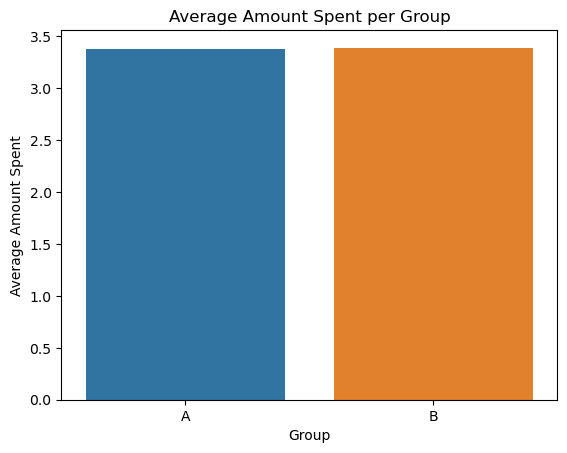

In [11]:
# Group the data by 'group' and calculate the mean total spent
grouped_data = df.groupby('group')['total_spent'].mean().reset_index()

# Plot the bar chart
sns.barplot(x='group', y='total_spent', data=grouped_data)
plt.title('Average Amount Spent per Group')
plt.xlabel('Group')
plt.ylabel('Average Amount Spent')
plt.show()

### Null Hypothesis:
- There is no correlation between the amount of time a person is in the experiment and their likelihood of converting.
### Alternative Hypothesis
- There is a correlation between the amount of time a person is in the experiment and their likelihood of converting.

### Methods
- Calculate Pearson's correlation coefficient and p-value
- Print correlation coefficient and p-value
- Perform hypothesis test
- Calculate the 95% confidence interval

In [15]:
# Calculate Pearson's correlation coefficient and p-value
corr, p_val = pearsonr(df['num_purchase_days'], df['converted'])

# Print correlation coefficient and p-value
print(f"Pearson correlation coefficient: {corr}")
print(f"p-value: {p_val}")

# Perform hypothesis test
alpha = 0.05
if p_val > alpha:
    print("Fail to reject the null hypothesis: there is no significant correlation between the number of purchase days and conversion")
else:
    print("Reject the null hypothesis: there is a significant correlation between the number of purchase days and conversion")

# Calculate the 95% confidence interval
r_z = np.arctanh(corr)
se = 1 / np.sqrt(len(df['num_purchase_days']) - 3)
z_critical = stats.norm.ppf(1 - alpha/2)
lo_z, hi_z = r_z - z_critical * se, r_z + z_critical * se
lo, hi = np.tanh((lo_z, hi_z))

# Print the confidence interval
print(f"95% Confidence Interval: ({lo}, {hi})")


Pearson correlation coefficient: 0.9726934546030179
p-value: 0.0
Reject the null hypothesis: there is a significant correlation between the number of purchase days and conversion
95% Confidence Interval: (0.9722120725927494, 0.9731666108899835)


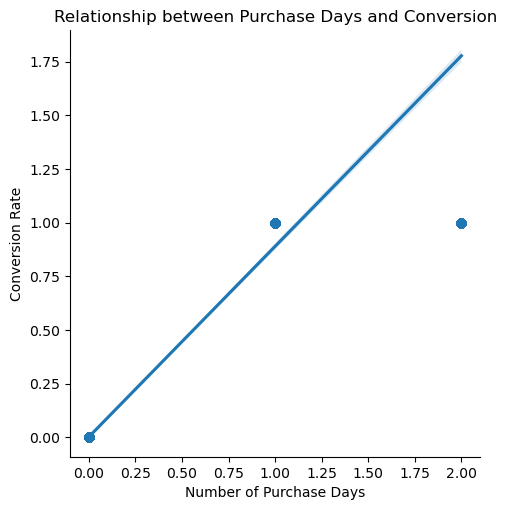

In [16]:
# Create scatter plot with best-fit line
sns.lmplot(x='num_purchase_days', y='converted', data=df)

# Add correlation coefficient to the plot
corr_coef, _ = pearsonr(df['num_purchase_days'], df['converted'])

# Add title and axis labels
plt.title('Relationship between Purchase Days and Conversion')
plt.xlabel('Number of Purchase Days')
plt.ylabel('Conversion Rate');

### Average spent per group by country

In [17]:
grouped = df.groupby(['country', 'group']).agg({'total_spent': 'mean'})
print(grouped)

               total_spent
country group             
AUS     A         1.668388
        B         2.080625
BRA     A         3.213933
        B         3.066117
CAN     A         3.601904
        B         4.198568
DEU     A         3.400589
        B         2.708085
ESP     A         2.178395
        B         3.234237
FRA     A         2.677874
        B         2.268101
GBR     A         2.108742
        B         4.498004
MEX     A         2.811946
        B         3.345506
TUR     A         3.685375
        B         2.488957
UNK     A         3.264873
        B         3.538448
USA     A         4.295363
        B         4.053452


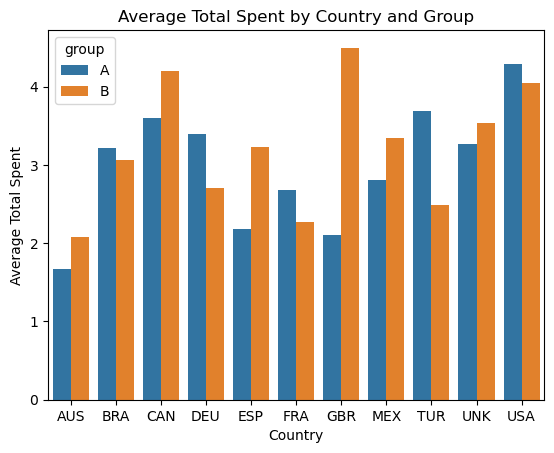

In [18]:
# Group the data by country and group, and calculate the mean total spent
grouped_data = df.groupby(['country', 'group'])['total_spent'].mean().reset_index()

# Plot the bar chart
sns.barplot(x='country', y='total_spent', hue='group', data=grouped_data)
plt.title('Average Total Spent by Country and Group')
plt.xlabel('Country')
plt.ylabel('Average Total Spent')
plt.show()

### Amount spent per group by gender

In [19]:
gender_group = df.groupby(['gender', 'group'])['total_spent'].mean().reset_index()
print(gender_group)

  gender group  total_spent
0      F     A     4.462831
1      F     B     4.129919
2      M     A     2.249476
3      M     B     2.600581
4      O     A     2.767339
5      O     B     2.769994
6      U     A     3.621754
7      U     B     3.735781


/var/folders/y7/q8w7scdn0wq8m_64wyrst42w0000gn/T/ipykernel_13107/2321520977.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gender_spent = df.groupby(['gender', 'group']).mean()[['total_spent']].reset_index()


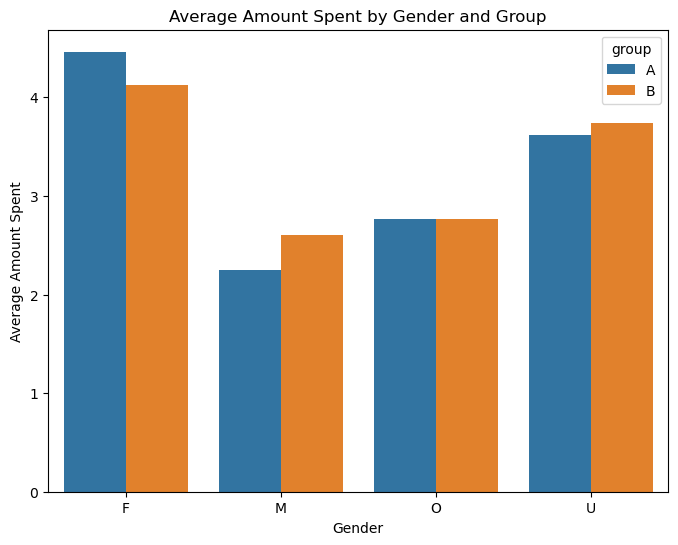

In [20]:
gender_spent = df.groupby(['gender', 'group']).mean()[['total_spent']].reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='total_spent', hue='group', data=gender_spent)
plt.title('Average Amount Spent by Gender and Group')
plt.xlabel('Gender')
plt.ylabel('Average Amount Spent')
plt.show();